## Simulating the eBOSS Instrument

This notebook goes through how to simulate eBOSS spectra given a model spectrum (specified in the `eboss.yaml` config file). The source used in this example is a 22.4 mag quasar spectrum at z=1.5.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import specsim.simulator

from astropy.io import fits
from astropy.table import Table, vstack

#### Compare specsim output in DESI and eBOSS modes

##### Initialize each simulator

In [12]:
desi = specsim.simulator.Simulator('desi', num_fibers=1, camera_output=True)
eboss = specsim.simulator.Simulator('eboss', num_fibers=1, camera_output=True)

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


##### Get simulated output for each camera

In [13]:
def get_camera_output(simulator, seed=123, eboss=False):
    gen = np.random.RandomState(seed)
    # Simulate the response of the spectrograph
    simulator.simulate()
    # Generate a random realization of the instrumental noise
    simulator.generate_random_noise(gen)
    
    if eboss:
        return(simulator._eboss_camera_output)

    else:
        return(simulator.camera_output)
    
desi_g, desi_r, desi_z = get_camera_output(desi)
eboss_b, eboss_r = get_camera_output(eboss, eboss=True)

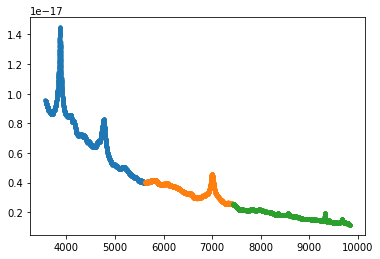

In [14]:
plt.plot(desi_g['wavelength'], desi_g['observed_flux'], '.')
plt.plot(desi_r['wavelength'], desi_r['observed_flux'], '.')
plt.plot(desi_z['wavelength'], desi_z['observed_flux'], '.');

Exclude first and last values which are not properly handled by the fit:

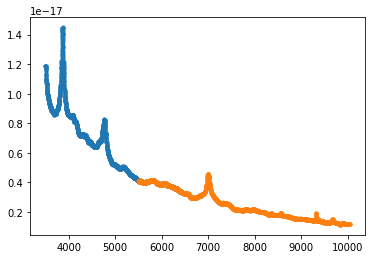

In [19]:
plt.plot(eboss_b['wavelength'][1:-1], eboss_b['observed_flux'][1:-1], '.')
plt.plot(eboss_r['wavelength'][1:-1], eboss_r['observed_flux'][1:-1], '.');

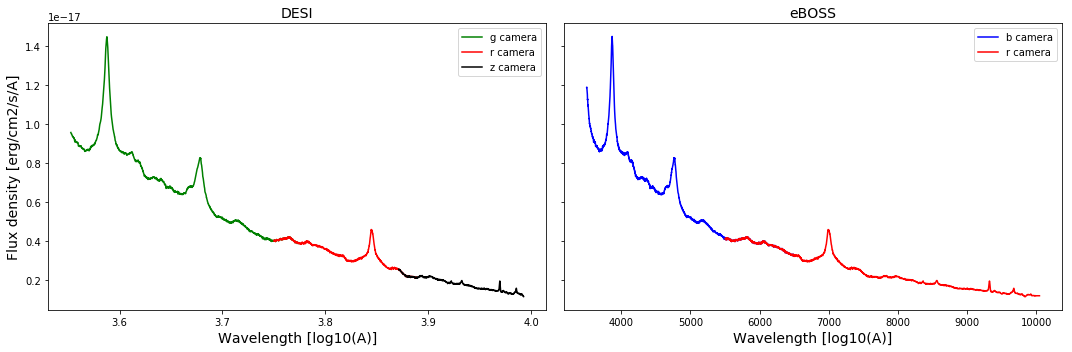

In [20]:
fs = 14

fig, axs = plt.subplots(1,2, figsize=(15,5), sharey=True)
axs = axs.ravel()
axs[0].plot(np.log10(desi_g['wavelength']), desi_g['observed_flux'], c='g', label='g camera')
axs[0].plot(np.log10(desi_r['wavelength']), desi_r['observed_flux'], c='r', label='r camera')
axs[0].plot(np.log10(desi_z['wavelength']), desi_z['observed_flux'], c='k', label='z camera')
axs[1].plot(eboss_b['wavelength'][1:-1], eboss_b['observed_flux'][1:-1], c='b', label='b camera')
axs[1].plot(eboss_r['wavelength'][1:-1], eboss_r['observed_flux'][1:-1], c='r', label='r camera')

axs[0].set_title('DESI', fontsize=fs)
axs[1].set_title('eBOSS', fontsize=fs)
axs[0].set_xlabel('Wavelength [log10(A)]', fontsize=fs)
axs[1].set_xlabel('Wavelength [log10(A)]', fontsize=fs)
axs[0].set_ylabel('Flux density [erg/cm2/s/A]', fontsize=fs)
axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.show()

##### Plot DESI and eBOSS simulated inverse variance

In [21]:
qso_path = os.path.join(os.getenv('SDSS'), 'spec-qso.dat')
qso_model = Table.read(qso_path, format='ascii')
wlen, flux = qso_model['WAVELENGTH'], qso_model['FLUX']

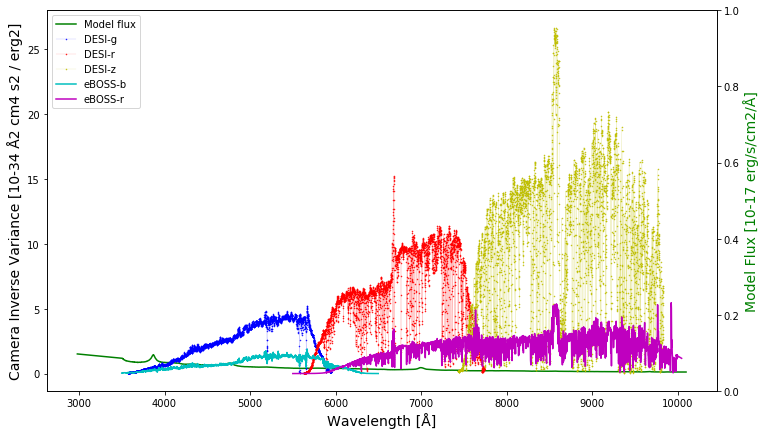

In [23]:
fs = 14

fig, ax1 = plt.subplots(figsize=(12,7))

ax2 = ax1.twinx()
ax1.plot(wlen, flux, 'g', label='Model flux') # 1e-17 erg/s/cm2/A
ax1.plot(desi_g['wavelength'], desi_g['flux_inverse_variance'] * 1e-34, 'b.-', ms=1, lw=0.1, 
         label='DESI-g') # 1e34 A2 cm4 s2 / erg2
ax1.plot(desi_r['wavelength'], desi_r['flux_inverse_variance'] * 1e-34, 'r.-',  ms=1, lw=0.1, 
         label='DESI-r') # 1e34 A2 cm4 s2 / erg2
ax1.plot(desi_z['wavelength'], desi_z['flux_inverse_variance'] * 1e-34, 'y.-',  ms=1, lw=0.1, 
         label='DESI-z') # 1e34 A2 cm4 s2 / erg2
ax1.plot(eboss_b['wavelength'], eboss_b['flux_inverse_variance'] * 1e-34, 'c', label='eBOSS-b')
ax1.plot(eboss_r['wavelength'], eboss_r['flux_inverse_variance'] * 1e-34, 'm', label='eBOSS-r')

ax1.legend(loc=2)
ax1.set_xlabel('Wavelength [Å]', fontsize=fs)
ax1.set_ylabel('Camera Inverse Variance [10-34 Å2 cm4 s2 / erg2]', fontsize=fs)
ax2.set_ylabel('Model Flux [10-17 erg/s/cm2/Å]', color='g', fontsize=fs)
plt.show()